The summaries coming from Google Forms are coupled with document IDs but that's not very convenient for data analysis. In this notebook, I will extract useful information about documents and do some sanity checks.

# Preparation

In [1]:
import sys
if '..' not in sys.path:
    sys.path.append('..')

In [2]:
import cort

In [3]:
from cort.core import corpora

In [32]:
import pandas as pd
from mturk.gformtools import visualize, extract_errors, unpack_json, chains_str_from_events
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
import os
from tqdm import tqdm
from mturk.extract_results import extract_results_from_log_file
from mturk.score_submissions import evaluate_submissions, adhoc_fix
import re
from pandas.core.dtypes.missing import notna

In [5]:
%%sh
cd ..
# this file is not commited to git to protect the privacy of annotators
# if you don't have this file, please ignore
python3 anonymize.py 

In [6]:
len(pd.read_csv('../data/annotations/summary.csv'))

217

In [19]:
summaries = pd.read_csv('../data/annotations/summary.csv')
summaries = summaries.drop_duplicates(['Document', 'Username'], keep='last')
summaries = summaries[summaries.Username.isin(['student1', 'student2', 'student3'])]

In [20]:
summaries

,Timestamp,Username,Total score,Document,Document [Score],Document [Feedback],Excerpt (for verification),Excerpt (for verification) [Score],Excerpt (for verification) [Feedback],Sentence 1,Sentence 1 [Score],Sentence 1 [Feedback],Sentence 2,Sentence 2 [Score],Sentence 2 [Feedback],Sentence 3,Sentence 3 [Score],Sentence 3 [Feedback]
1,2019/06/16 5:14:36 pm EET,student2,0.00 / 3,student2-2019-03-29-question-456.html,-- / 0,NaN,NaN,NaN,NaN,Robert Goldberg is involved with the new CBS s...,-- / 1,NaN,NaN,-- / 1,NaN,NaN,-- / 1,NaN
2,2019/06/16 5:22:11 pm EET,student2,0.00 / 3,student2-2019-03-29-question-058.html,-- / 0,NaN,NaN,NaN,NaN,Iraq is about to be rebuilt after the fall of ...,-- / 1,NaN,This means a change for the coalition's role i...,-- / 1,NaN,Military analyst and ex-general Claudia Kenned...,-- / 1,NaN
3,2019/06/16 5:26:28 pm EET,student2,0.00 / 3,student2-2019-03-29-question-251.html,-- / 0,NaN,NaN,NaN,NaN,Basketball coach Larry Eustachy resigned after...,-- / 1,NaN,The scandal damaged his credibility too much.,-- / 1,NaN,He received a large sum from the university as...,-- / 1,NaN
4,2019/06/16 5:29:32 pm EET,student2,0.00 / 3,student2-2019-03-29-question-157.html,-- / 0,NaN,NaN,NaN,NaN,The former Soviet national anthem has been res...,-- / 1,NaN,Putin supported the restoration.,-- / 1,NaN,Some criticized the move because of the totali...,-- / 1,NaN
5,2019/06/16 5:32:58 pm EET,student2,0.00 / 3,student2-2019-03-29-question-083.html,-- / 0,NaN,NaN,NaN,NaN,Many Palestinians died in Israeli air raids in...,-- / 1,NaN,The air raids were a response to a Palestiniai...,-- / 1,NaN,Palestinian leaders call for international int...,-- / 1,NaN
6,2019/06/16 5:34:16 pm EET,student2,0.00 / 3,student2-2019-03-29-question-446.html,-- / 0,NaN,NaN,NaN,NaN,Kenneth J. Thygerson resigned from his post as...,-- / 1,NaN,NaN,-- / 1,NaN,NaN,-- / 1,NaN
7,2019/06/16 5:37:39 pm EET,student2,0.00 / 3,student2-2019-03-29-question-394.html,-- / 0,NaN,NaN,NaN,NaN,The Presidential Advisory Group on Cross-Strai...,-- / 1,NaN,The Taiwanese constitution plays a key role in...,-- / 1,NaN,NaN,-- / 1,NaN
11,2019/06/16 5:58:33 pm EET,student2,0.00 / 3,student2-2019-03-29-question-079.html,-- / 0,NaN,NaN,NaN,NaN,"Hisham Mekki, the head of Palestinian State Te...",-- / 1,NaN,The attack took place at a hotel.,-- / 1,NaN,NaN,-- / 1,NaN
12,2019/06/16 6:02:13 pm EET,student2,0.00 / 3,student2-2019-03-29-question-265.html,-- / 0,NaN,NaN,NaN,NaN,Governor Richardson talks about the nuclear mi...,-- / 1,NaN,He says that negotiating with the North Korean...,-- / 1,NaN,He stresses the importance of arms control agr...,-- / 1,NaN
13,2019/06/16 8:11:23 pm EET,student2,0.00 / 3,student2-2019-03-29-question-223.html,-- / 0,NaN,__ __ __ exactly __ __ react __ __ __ __ __ __...,-- / 0,NaN,There was a road-cave accident in a Chinese city.,-- / 1,NaN,The government responded quickly by sending ou...,-- / 1,NaN,Emergency repair workers were sent to the scen...,-- / 1,NaN


In [21]:
summaries.Username.value_counts()

student3    77
student2    74
student1    59
Name: Username, dtype: int64

# Eye-balling

In [15]:
summaries['Sentence 1'].apply(print)
None

Robert Goldberg is involved with the new CBS show "Island Son".
Iraq is about to be rebuilt after the fall of Saddam Hussein's regime.
Basketball coach Larry Eustachy resigned after the picture scandal.
The former Soviet national anthem has been restored in Russia with minor changes to the lyrics.
Many Palestinians died in Israeli air raids in the Gaza Strip.
Kenneth J. Thygerson resigned from his post as president of a thrift holding company.
The Presidential Advisory Group on Cross-Strait Relations is discussing the One China issue with members of China's DPP.
Hisham Mekki, the head of Palestinian State Television and Radio has been shot.
Governor Richardson talks about the nuclear missile situation in North Korea.
There was a road-cave accident in a Chinese city.
Dan Abrams, a television host, is introducing the upcoming topics on his show.
The US Securities and Exchange Commision filed a number of issues recently.
Tanshui, a little town in Taiwan, used to be called the "foreign dis

In [16]:
summaries['Sentence 2'].apply(print)
None

nan
This means a change for the coalition's role in the country.
The scandal damaged his credibility too much.
Putin supported the restoration.
The air raids were a response to a Palestiniain terrorist attack on an Israeli school bus earlier this week.
nan
The Taiwanese constitution plays a key role in the issue.
The attack took place at a hotel.
He says that negotiating with the North Koreans is difficult and risky.
The government responded quickly by sending out text messages to the residents.
One of the topics involve two mothers who lost their daughters to sex offenders.
They include a range of companies buying shares and stocks from each other.
Its educational institutions include Tamkang Middle School and Tamkang University.
The expensive chep plays a short advertisement about itself.
Multiple Enron executives have been charged with fraud since the company's collapse.
nan
South Korea performed best among Asian countries.
Various volunteer groups and organizations took part in the

In [17]:
summaries['Sentence 3'].apply(print)
None

nan
Military analyst and ex-general Claudia Kennedy explains the possibilities.
He received a large sum from the university as a buyout.
Some criticized the move because of the totalitarian nature of the Soviet Union.
Palestinian leaders call for international intervention.
nan
nan
nan
He stresses the importance of arms control agreements.
Emergency repair workers were sent to the scene to repair the damaged sewage pipes.
He also mentions an earlier comment he made about the Michael Jackson case and that viewers can respond to it.
nan
Tanshui used to be an agricultural town in the mountains.
The chip is the first of its kind.
A settlement has been made about conflict of interest in stock research.
nan
South Korean atheletes, many of whom are veterans, should provide an inspiration to disabled and sports communities.
The revival has made the establishment of a now succesful wax apple festival. 
nan
nan
Sometimes, the emergency drills might be called of for different reasons, such as col

# Read in CoNLL files

In [34]:
def find_conll_file(doc):
    '''
    Given the name of an annotation document (e.g. student2-2019-03-29-question-251.html), 
    return the path to its source CoNLL file
    '''
    paths = [s for s in glob('../output/mturk/*/%s' %doc) if '.bak' not in s]
    if len(paths) != 1: 
        print("Ignored document %s because we found %d matching files" %(doc, len(paths)))
        return None
    with open(paths[0]) as f:
        s = f.read()
    conll_file, = re.findall(r'name="conll_file" value="([\w\d/\-\.]+)"', s)
    return conll_file

summaries['conll_file'] = summaries.Document.apply(find_conll_file)

In [35]:
summaries['conll_file_sort'] = summaries.conll_file.str.replace(r'output/conll-2012-transformed/[\w\-_]+/', '')

In [36]:
%%time
from cort.core.corpora import Corpus
def read_conll_file(path):
    with open('../' + path) as f:
        corpus = Corpus.from_file('', f)
    return corpus.documents[0]

summaries['doc'] = summaries.conll_file.apply(read_conll_file)

/Users/cumeo/anaconda3/envs/EvEn/lib/python3.6/site-packages/jpype/_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)
/Users/cumeo/anaconda3/envs/EvEn/lib/python3.6/site-packages/StanfordDependencies/JPypeBackend.py:160: UserWarning: This jar doesn't support universal dependencies, falling back to Stanford Dependencies. To suppress this message, call with universal=False
  warnings.warn("This jar doesn't support universal "


CPU times: user 37.9 s, sys: 1.12 s, total: 39 s
Wall time: 30.6 s


# Format the data frame

In [40]:
summaries['num_sentences_in_doc'] = summaries.doc.apply(lambda doc: len(doc.sentence_spans))

In [41]:
summaries['transformation'] = summaries.conll_file.str.extract(r'/([\w-]+)/\s*(?:dev|test)')
summaries['pct_change'] = (summaries.transformation
                           .str.replace('orig', 'nonmen_0')
                           .str.extract(r'nonmen_(\d+)')
                           .astype(int))

In [42]:
summaries['has_sent1'] = summaries['Sentence 1'].notna()
summaries['has_sent2'] = summaries['Sentence 2'].notna()
summaries['has_sent3'] = summaries['Sentence 3'].notna()

In [43]:
summaries['sents'] = summaries.apply(lambda row: [row['Sentence 1'], row['Sentence 2'], row['Sentence 3']], axis=1)
summaries['sents'] = summaries.sents.apply(lambda sents: [s for s in sents if s and notna(s)])

In [48]:
summaries_formatted = summaries[['Username', 'Document', 'conll_file', 'num_sentences_in_doc', 
                                 'transformation', 'pct_change', 'sents', 'has_sent1', 'has_sent2', 'has_sent3']]

In [61]:
summaries_formatted.to_json('../output/summaries_formatted.json', orient='records', lines=True)

# Try plotting

In [22]:
counts = (summaries.groupby(['transformation', 'pct_change'])
          .agg({'conll_file': len, 'has_sent1': 'sum', 
                'has_sent2': 'sum', 'has_sent3': 'sum'}).reset_index())
counts['pct_has_sent1'] = counts['has_sent1'] / counts['conll_file']
counts['pct_has_sent2'] = counts['has_sent2'] / counts['conll_file']
counts['pct_has_sent3'] = counts['has_sent3'] / counts['conll_file']
counts2 = pd.wide_to_long(df=counts, stubnames='pct_has_sent', i=['transformation', 'pct_change'], j='sent_id')

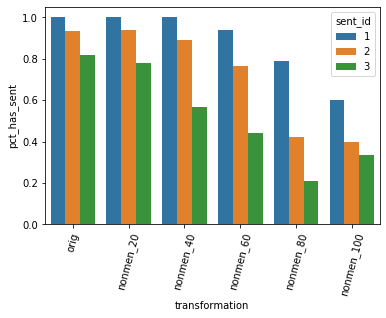

In [23]:
df = (counts2.reset_index().sort_values('pct_change'))
g = sns.barplot(x='transformation', y='pct_has_sent', hue='sent_id', data=df)
g.set_xticklabels(g.get_xticklabels(), rotation=75)
None

# More eyeballing

In [24]:
summaries[summaries.transformation.isin(['orig', 'nonmen_20', 'nonmen_40']) & 
          ~summaries.has_sent2 & (summaries.num_sentences_in_doc >= 10)]

,Timestamp,Username,Total score,Document,Document [Score],Document [Feedback],Excerpt (for verification),Excerpt (for verification) [Score],Excerpt (for verification) [Feedback],Sentence 1,...,Sentence 3 [Feedback],conll_file,conll_file_sort,doc,num_sentences,transformation,pct_change,has_sent1,has_sent2,has_sent3
106,2019/06/23 9:22:46 pm EET,student1,0.00 / 3,student1-2019-03-14-question-106.html,-- / 0,NaN,The president kept __ __ __ __ __ __ the trip ...,-- / 0,NaN,"The president had visits in Los Angeles, Gambi...",...,NaN,output/conll-2012-transformed/nonmen_40/dev/mz...,dev/mz_sinorama_10_ectb_1030___part_001.m_gold...,(mz/sinorama/10/ectb_1030); part 001,12,nonmen_40,40,True,False,False
127,2019/06/25 10:48:31 pm EET,student1,0.00 / 3,student1-2019-03-14-question-245.html,-- / 0,NaN,"__ __ well , based on your understanding __ __...",-- / 0,NaN,Government needs emergency plans.,...,NaN,output/conll-2012-transformed/nonmen_40/test/b...,test/bc_cctv_00_cctv_0005___part_015.m_gold_conll,(bc/cctv/00/cctv_0005); part 015,23,nonmen_40,40,True,False,False
140,2019/06/27 10:22:37 am EET,student3,0.00 / 3,student3-2019-03-29-question-162.html,-- / 0,NaN,"p. 098 __ __ Kuantu Bridge __ Pali , a town wh...",-- / 0,NaN,Bridges in the town Pali remind of the golden ...,...,NaN,output/conll-2012-transformed/nonmen_40/dev/mz...,dev/mz_sinorama_10_ectb_1050___part_006.m_gold...,(mz/sinorama/10/ectb_1050); part 006,11,nonmen_40,40,True,False,False
176,2019/06/28 2:01:08 pm EET,student3,0.00 / 3,student3-2019-03-29-question-137.html,-- / 0,NaN,Time now to __ the __ news with Carrie Lee in ...,-- / 0,NaN,News about the wins and losses of the stock ma...,...,NaN,output/conll-2012-transformed/nonmen_40/dev/bn...,dev/bn_cnn_02_cnn_0210___part_000.m_gold_conll,(bn/cnn/02/cnn_0210); part 000,26,nonmen_40,40,True,False,False
178,2019/06/28 2:05:37 pm EET,student3,0.00 / 3,student3-2019-03-29-question-037.html,-- / 0,NaN,"The Bush administration , urging the Supreme C...",-- / 0,NaN,The Bush administration said minors have n't t...,...,NaN,output/conll-2012-transformed/nonmen_20/dev/nw...,dev/nw_wsj_24_wsj_2449___part_000.m_gold_conll,(nw/wsj/24/wsj_2449); part 000,10,nonmen_20,20,True,False,False


In [25]:
summaries[summaries.transformation.isin(['orig', 'nonmen_20', 'nonmen_40']) & 
          ~summaries.has_sent3 & (summaries.num_sentences_in_doc >= 10)]

,Timestamp,Username,Total score,Document,Document [Score],Document [Feedback],Excerpt (for verification),Excerpt (for verification) [Score],Excerpt (for verification) [Feedback],Sentence 1,...,Sentence 3 [Feedback],conll_file,conll_file_sort,doc,num_sentences,transformation,pct_change,has_sent1,has_sent2,has_sent3
106,2019/06/23 9:22:46 pm EET,student1,0.00 / 3,student1-2019-03-14-question-106.html,-- / 0,NaN,The president kept __ __ __ __ __ __ the trip ...,-- / 0,NaN,"The president had visits in Los Angeles, Gambi...",...,NaN,output/conll-2012-transformed/nonmen_40/dev/mz...,dev/mz_sinorama_10_ectb_1030___part_001.m_gold...,(mz/sinorama/10/ectb_1030); part 001,12,nonmen_40,40,True,False,False
127,2019/06/25 10:48:31 pm EET,student1,0.00 / 3,student1-2019-03-14-question-245.html,-- / 0,NaN,"__ __ well , based on your understanding __ __...",-- / 0,NaN,Government needs emergency plans.,...,NaN,output/conll-2012-transformed/nonmen_40/test/b...,test/bc_cctv_00_cctv_0005___part_015.m_gold_conll,(bc/cctv/00/cctv_0005); part 015,23,nonmen_40,40,True,False,False
130,2019/06/27 9:48:08 am EET,student3,0.00 / 3,student3-2019-03-29-question-083.html,-- / 0,NaN,Like we could see each other __ And then I 'll...,-- / 0,NaN,Two people a talking about a great variety of ...,...,NaN,output/conll-2012-transformed/nonmen_20/dev/tc...,dev/tc_ch_00_ch_0010___part_002.m_gold_conll,(tc/ch/00/ch_0010); part 002,93,nonmen_20,20,True,True,False
140,2019/06/27 10:22:37 am EET,student3,0.00 / 3,student3-2019-03-29-question-162.html,-- / 0,NaN,"p. 098 __ __ Kuantu Bridge __ Pali , a town wh...",-- / 0,NaN,Bridges in the town Pali remind of the golden ...,...,NaN,output/conll-2012-transformed/nonmen_40/dev/mz...,dev/mz_sinorama_10_ectb_1050___part_006.m_gold...,(mz/sinorama/10/ectb_1050); part 006,11,nonmen_40,40,True,False,False
143,2019/06/27 10:33:31 am EET,student3,0.00 / 3,student3-2019-03-29-question-139.html,-- / 0,NaN,"The morning papers , because morning papers ar...",-- / 0,NaN,The lost girl Elizabeth Smart came home to her...,...,NaN,output/conll-2012-transformed/orig/dev/bn_cnn_...,dev/bn_cnn_02_cnn_0250___part_000.m_gold_conll,(bn/cnn/02/cnn_0250); part 000,34,orig,0,True,True,False
159,2019/06/28 12:33:08 pm EET,student3,0.00 / 3,student3-2019-03-29-question-194.html,-- / 0,NaN,Everyone will hate you because you follow me ....,-- / 0,NaN,Everyone will hate the followers of the son of...,...,NaN,output/conll-2012-transformed/orig/dev/pt_nt_4...,dev/pt_nt_40_nt_4010___part_001.m_gold_conll,(pt/nt/40/nt_4010); part 001,41,orig,0,True,True,False
161,2019/06/28 12:39:01 pm EET,student3,0.00 / 3,student3-2019-03-29-question-063.html,-- / 0,NaN,"Xinhua News __ , Beijing , September 1st On Au...",-- / 0,NaN,Representatives of China and Korea talk in Bei...,...,NaN,output/conll-2012-transformed/nonmen_20/dev/nw...,dev/nw_xinhua_03_chtb_0300___part_000.m_gold_c...,(nw/xinhua/03/chtb_0300); part 000,13,nonmen_20,20,True,True,False
164,2019/06/28 12:47:30 pm EET,student3,0.00 / 3,student3-2019-03-29-question-036.html,-- / 0,NaN,Common Cause __ both the Senate Ethics Committ...,-- / 0,NaN,Arizona businessman Charles Keating ist he su...,...,NaN,output/conll-2012-transformed/nonmen_40/dev/nw...,dev/nw_wsj_24_wsj_2446___part_000.m_gold_conll,(nw/wsj/24/wsj_2446); part 000,35,nonmen_40,40,True,True,False
170,2019/06/28 1:44:32 pm EET,student3,0.00 / 3,student3-2019-03-29-question-088.html,-- / 0,NaN,__ I mean they both __ the advantages and __ w...,-- / 0,NaN,One of the speakers thinks about Spain.,...,NaN,output/conll-2012-transformed/nonmen_40/dev/tc...,dev/tc_ch_00_ch_0040___part_001.m_gold_conll,(tc/ch/00/ch_0040); part 001,94,nonmen_40,40,True,True,False
172,2019/06/28 1:56:03 pm EET,student3,0.00 / 3,student3-2019-03-29-question-048.html,-- / 0,NaN,"Xinhua News Agency , Nanning , Jan. 16th , by ...",-- / 0,NaN,Fangchenggang City is a recently established c...,...,NaN,output/conll-2012-transformed/nonmen_20/dev/nw...,dev/nw_xinhua_01_chtb_0120___part_

In [26]:
(summaries[summaries.transformation.isin(['nonmen_100']) & summaries.has_sent1]
 [['Document', 'conll_file_sort', 'Sentence 1', 'Sentence 2', 'Sentence 3']]).values

array([['student2-2019-03-29-question-456.html',
        'test/nw_wsj_23_wsj_2368___part_000.m_gold_conll',
        'Robert Goldberg is involved with the new CBS show "Island Son".',
        nan, nan],
       ['student2-2019-03-29-question-399.html',
        'test/mz_sinorama_10_ectb_1049___part_002.m_gold_conll',
        'Tanshui, a little town in Taiwan, used to be called the "foreign district".',
        'Its educational institutions include Tamkang Middle School and Tamkang University.',
        'Tanshui used to be an agricultural town in the mountains.'],
       ['student2-2019-03-29-question-412.html',
        'test/mz_sinorama_10_ectb_1069___part_000.m_gold_conll',
        'A minority of middle-aged people experience a crisis at this age.',
        'The crisis often has to do with changes in their powers and abilities.',
        'Middle-aged men find it especially difficult to talk about their feelings.'],
       ['student2-2019-03-29-question-401.html',
        'test/mz_sinoram

In [27]:
(summaries[summaries.transformation.isin(['nonmen_80']) & summaries.has_sent3]
 [['Document', 'conll_file_sort', 'Sentence 1', 'Sentence 2', 'Sentence 3']]).values

array([['student2-2019-03-29-question-223.html',
        'test/bc_cctv_00_cctv_0005___part_004.m_gold_conll',
        'There was a road-cave accident in a Chinese city.',
        'The government responded quickly by sending out text messages to the residents.',
        'Emergency repair workers were sent to the scene to repair the damaged sewage pipes.'],
       ['student1-2019-03-14-question-286.html',
        'test/bn_abc_00_abc_0029___part_000.m_gold_conll',
        'There is a Wind Cave in South Dakota.',
        'The Wind Cave is a touristic attraction.',
        'The Wind Cave has crystals in it. '],
       ['student2-2019-03-29-question-259.html',
        'test/bc_msnbc_00_msnbc_0007___part_004.m_gold_conll',
        'According to a new study, North Korea could be developing nuclear weapons.',
        'Nicholas Burns believes that the U.S. still has an enourmous influence on North Korea.',
        'The U.S. policy is to de-nuclearize North Korea.'],
       ['student2-2019-03-29-

In [28]:
def print_answers(df):
    def print_row(row):
        print('%s (%s)' %(row['Document'], row['transformation']))
        print(row['Sentence 1'])
        print(row['Sentence 2'])
        print(row['Sentence 3'])
        print()
    df.apply(print_row, axis=1)

In [29]:
print_answers(summaries[(~summaries['has_sent3']) & (summaries['transformation'] == 'orig')])

student3-2019-03-29-question-021.html (orig)
The company American Physicians Service Group Inc purchased part of the company Prime Medical Services Inc for 5 million dollar.
nan
nan

student3-2019-03-29-question-183.html (orig)
Texas Instruments Inc. had a pr coup with an advertisement in a magazine that included a speech synthesizer.
nan
nan

student3-2019-03-29-question-157.html (orig)
Bill Clinton and his wife Hillary Clinton are the most admired people by Americans.
nan
nan

student3-2019-03-29-question-139.html (orig)
The lost girl Elizabeth Smart came home to her parents.
Her mother is thankful for her return
nan

student3-2019-03-29-question-194.html (orig)
Everyone will hate the followers of the son of the father in heaven.
The ones that remain faithful to him will be rewarded by god.
nan

student3-2019-03-29-question-181.html (orig)
US officials try to reduce the impacts of Black Monday.
Several companies had severe losses.
nan

student1-2019-03-14-question-140.html (orig)
 Am

In [30]:
print_answers(summaries[summaries.transformation == 'nonmen_80'])

student2-2019-03-29-question-446.html (nonmen_80)
Kenneth J. Thygerson resigned from his post as president of a thrift holding company.
nan
nan

student2-2019-03-29-question-394.html (nonmen_80)
The Presidential Advisory Group on Cross-Strait Relations is discussing the One China issue with members of China's DPP.
The Taiwanese constitution plays a key role in the issue.
nan

student2-2019-03-29-question-223.html (nonmen_80)
There was a road-cave accident in a Chinese city.
The government responded quickly by sending out text messages to the residents.
Emergency repair workers were sent to the scene to repair the damaged sewage pipes.

student2-2019-03-29-question-385.html (nonmen_80)
nan
nan
nan

student2-2019-03-29-question-208.html (nonmen_80)
Christians share their faith in the sacrifice of a loaf of bread.
The people of Israel (Jews) are wrong about their sacrifices.
nan

student2-2019-03-29-question-424.html (nonmen_80)
Changes are happening in the oil industry throughout the yea

In [31]:
print_answers(summaries[summaries.transformation == 'nonmen_100'])

student2-2019-03-29-question-456.html (nonmen_100)
Robert Goldberg is involved with the new CBS show "Island Son".
nan
nan

student2-2019-03-29-question-399.html (nonmen_100)
Tanshui, a little town in Taiwan, used to be called the "foreign district".
Its educational institutions include Tamkang Middle School and Tamkang University.
Tanshui used to be an agricultural town in the mountains.

student2-2019-03-29-question-412.html (nonmen_100)
A minority of middle-aged people experience a crisis at this age.
The crisis often has to do with changes in their powers and abilities.
Middle-aged men find it especially difficult to talk about their feelings.

student2-2019-03-29-question-401.html (nonmen_100)
The government is planning to build a riverside highway to Tanshui.
Another Tanshui project involves building high-rise apartments.
Some residents of Tanshui are unhappy with these projects.

student2-2019-03-29-question-403.html (nonmen_100)
nan
nan
nan

student1-2019-03-14-question-272.htm